In [1]:
# Import libraries
import torch
from torch import optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime

from pathlib import Path

# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

from params import PROJECT_PATH

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [3]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET / "pairs_train.csv",
    features_directory=params.siamese.DATASET / "features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET / "pairs_train.csv",
    features_directory=params.siamese.DATASET / "features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET / "pairs_test.csv",
    features_directory=params.siamese.DATASET / "features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [4]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [5]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (67736 samples)
15.0 % of the data for validation (14516 samples)
15.0 % of the data for testing (14516 samples)


## GPU?

In [6]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [7]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

#Visualize the model
print(model)

SiameseNetwork(
  (mlp): Sequential(
    (0): Linear(in_features=78, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): ReLU()
  )
)


In [8]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [9]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.08710449218848497
Validation loss:  0.08010278092410071
Train accuracy:  74.3666587929609
Validation accuracy:  76.95646183521632


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.07425830414038542
Validation loss:  0.07293092918947405
Train accuracy:  78.38224873036495
Validation accuracy:  78.65803251584458


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.06877873338780052
Validation loss:  0.07054102941855198
Train accuracy:  80.24979331522381
Validation accuracy:  79.78093138605676


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0638986248399876
Validation loss:  0.06441248593942184
Train accuracy:  81.80435809613795
Validation accuracy:  81.53761366767705


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05901856612452817
Validation loss:  0.05647118413402383
Train accuracy:  83.35744655722216
Validation accuracy:  84.30008266740148


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05418232847726266
Validation loss:  0.06088355427304291
Train accuracy:  84.78652415259242
Validation accuracy:  83.19096169743732


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05072891761085355
Validation loss:  0.0480323122888147
Train accuracy:  85.82290067320184
Validation accuracy:  86.74565996142188


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04611061588703629
Validation loss:  0.04306155513758701
Train accuracy:  87.35384433683713
Validation accuracy:  88.68145494626619


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04128972267269441
Validation loss:  0.04056000009605801
Train accuracy:  88.80801936931617
Validation accuracy:  89.06034720308625


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03851862090777841
Validation loss:  0.03726663239021265
Train accuracy:  89.46202905397425
Validation accuracy:  90.07991182143842


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03433958437457343
Validation loss:  0.03461005427517686
Train accuracy:  90.78628794141963
Validation accuracy:  91.04436483879857


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03238632803874282
Validation loss:  0.0305068944150065
Train accuracy:  91.33843155781268
Validation accuracy:  91.60236979884266


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.028590938588208586
Validation loss:  0.027175316445545872
Train accuracy:  92.41171607417031
Validation accuracy:  92.98704877376687


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02717736630055902
Validation loss:  0.02576343321122459
Train accuracy:  92.84132514467935
Validation accuracy:  93.22816202810692


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02537126019878473
Validation loss:  0.027553664914246174
Train accuracy:  93.27388685484823
Validation accuracy:  92.78726922017084


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.023603527123377613
Validation loss:  0.023325057648992092
Train accuracy:  93.76550135821424
Validation accuracy:  93.793055938275


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.020998689692073465
Validation loss:  0.02329964883264466
Train accuracy:  94.52728239045707
Validation accuracy:  93.68283273629099


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01873450863022952
Validation loss:  0.01781828038698054
Train accuracy:  95.0676154482107
Validation accuracy:  95.25351336456325


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0180699290123762
Validation loss:  0.020461341251295045
Train accuracy:  95.204913192394
Validation accuracy:  94.57839625241114


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.017034016643686888
Validation loss:  0.017856501549531577
Train accuracy:  95.52970355497816
Validation accuracy:  95.54284926977128


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01595003127381628
Validation loss:  0.01401634063850678
Train accuracy:  95.88844927365065
Validation accuracy:  96.36952328465142


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0148925335314459
Validation loss:  0.010527503192588885
Train accuracy:  96.1822369198063
Validation accuracy:  97.5544227059796


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013575462514061457
Validation loss:  0.011529427091488492
Train accuracy:  96.49374040392111
Validation accuracy:  97.18241939928355


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.012296140551155061
Validation loss:  0.012739631513519303
Train accuracy:  96.86724932089288
Validation accuracy:  96.74152659134748


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.012658085575990371
Validation loss:  0.017449665299743938
Train accuracy:  96.72109365773001
Validation accuracy:  95.43262606778727


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011008788273529949
Validation loss:  0.01313681334733044
Train accuracy:  97.22304239990551
Validation accuracy:  96.57619178837145


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011014480337261367
Validation loss:  0.019198817244037526
Train accuracy:  97.1536553678989
Validation accuracy:  94.9917332598512


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010499381868307662
Validation loss:  0.013257341685044345
Train accuracy:  97.31605054919098
Validation accuracy:  96.45907963626344


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.010139422795477625
Validation loss:  0.01161469346618009
Train accuracy:  97.39577182000708
Validation accuracy:  97.07908514742353


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009430907989656016
Validation loss:  0.00982085319999031
Train accuracy:  97.58916971772764
Validation accuracy:  97.40975475337558


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008952108182354255
Validation loss:  0.00835098097068032
Train accuracy:  97.70579898429196
Validation accuracy:  97.83686966106366


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008465094721811886
Validation loss:  0.006154123111115153
Train accuracy:  97.83423880949569
Validation accuracy:  98.58087627445578


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008431848569054639
Validation loss:  0.006564521805141203
Train accuracy:  97.87557576473367
Validation accuracy:  98.43620832185175


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008386586086580054
Validation loss:  0.008331716592969282
Train accuracy:  97.89181528286288
Validation accuracy:  97.91953706255167


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007598831025466703
Validation loss:  0.006064438039543608
Train accuracy:  98.08373686075352
Validation accuracy:  98.56020942408377


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008057930512482176
Validation loss:  0.013869559197452756
Train accuracy:  97.99220503129798
Validation accuracy:  96.37641223477542


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007939313272782886
Validation loss:  0.006058765171169578
Train accuracy:  98.02173142789654
Validation accuracy:  98.53265362358776


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0064371687991542845
Validation loss:  0.007389540709185902
Train accuracy:  98.37752450690918
Validation accuracy:  98.1262055662717


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006864269865576505
Validation loss:  0.008764720084925187
Train accuracy:  98.19003188850833
Validation accuracy:  97.79553596031965


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006087385639513125
Validation loss:  0.006668794404772738
Train accuracy:  98.5162985709224
Validation accuracy:  98.33287406999173


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005990825172221751
Validation loss:  0.0046543798436070195
Train accuracy:  98.50153537262312
Validation accuracy:  98.87710112978782


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005733675020021352
Validation loss:  0.006258060310511862
Train accuracy:  98.55025392701074
Validation accuracy:  98.43620832185175


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0055624685009257255
Validation loss:  0.004148857686376314
Train accuracy:  98.59897248139838
Validation accuracy:  99.06999173325985


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005666379469013276
Validation loss:  0.004005156367163826
Train accuracy:  98.58716192275895
Validation accuracy:  99.03554698263984


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006210916388931142
Validation loss:  0.004222174302268658
Train accuracy:  98.45429313806542
Validation accuracy:  99.02176908239184


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005366118826636934
Validation loss:  0.004743578929930006
Train accuracy:  98.63440415731664
Validation accuracy:  98.7393221273078


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005662594888468358
Validation loss:  0.005496928915545541
Train accuracy:  98.56944608479981
Validation accuracy:  98.60843207495178


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004958328991034354
Validation loss:  0.004908162183518058
Train accuracy:  98.78794141962915
Validation accuracy:  98.7875447781758


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005290532972297796
Validation loss:  0.0033668515760664898
Train accuracy:  98.69936222983347
Validation accuracy:  99.3317718379719


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004054066844238804
Validation loss:  0.004375074591101988
Train accuracy:  99.02710523207747
Validation accuracy:  98.95976853127583


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004534991779492164
Validation loss:  0.003978740510075365
Train accuracy:  98.85289949214598
Validation accuracy:  99.06999173325985


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004852272572331799
Validation loss:  0.003735135036052947
Train accuracy:  98.79975197826857
Validation accuracy:  99.16643703499587


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0049807407116698585
Validation loss:  0.004932508391578424
Train accuracy:  98.77613086098972
Validation accuracy:  98.8013226784238


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004885970460839316
Validation loss:  0.007129929533088785
Train accuracy:  98.74660446439117
Validation accuracy:  98.1193166161477


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0042333375364436475
Validation loss:  0.006648717335289927
Train accuracy:  98.96952875871028
Validation accuracy:  98.21576191788371


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004566672219823592
Validation loss:  0.006214577991860029
Train accuracy:  98.89718908704381
Validation accuracy:  98.45687517222375


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004546539914707202
Validation loss:  0.00305898135757722
Train accuracy:  98.86618637061532
Validation accuracy:  99.3593276384679


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0036531441530161753
Validation loss:  0.006312116475915331
Train accuracy:  99.10977914255345
Validation accuracy:  98.38798567098374


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0037343414145063632
Validation loss:  0.005671538623862198
Train accuracy:  99.04186843037675
Validation accuracy:  98.53265362358776


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0037322157441626977
Validation loss:  0.003177450450818313
Train accuracy:  99.06106058816582
Validation accuracy:  99.22154863598787


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0036069336043876563
Validation loss:  0.0028629910913942225
Train accuracy:  99.12454234085273
Validation accuracy:  99.3593276384679


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003659223860861405
Validation loss:  0.003927097085551543
Train accuracy:  99.1230660210228
Validation accuracy:  99.01488013226785


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0037812214758954203
Validation loss:  0.005057972199427136
Train accuracy:  99.03743947088697
Validation accuracy:  98.70487737668779


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003601319310928117
Validation loss:  0.002579850239047395
Train accuracy:  99.09796858391402
Validation accuracy:  99.4351060898319


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0037318956273114548
Validation loss:  0.001913088309221659
Train accuracy:  99.06991850714539
Validation accuracy:  99.63488564342794


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003389111209952741
Validation loss:  0.005522081753575461
Train accuracy:  99.21902680996811
Validation accuracy:  98.60154312482777


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0036032978892484653
Validation loss:  0.0049433339251787915
Train accuracy:  99.15111609779143
Validation accuracy:  98.7875447781758


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003125584059473166
Validation loss:  0.004982368185673123
Train accuracy:  99.23379000826739
Validation accuracy:  98.82198952879581


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003700500448710154
Validation loss:  0.003491795699764453
Train accuracy:  99.1023975434038
Validation accuracy:  99.13888123449986


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00411718136034475
Validation loss:  0.003732353475535625
Train accuracy:  98.99019723632928
Validation accuracy:  99.09754753375586


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030728588645839825
Validation loss:  0.003685783974350418
Train accuracy:  99.2766032833353
Validation accuracy:  99.22154863598787


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0035921005392315197
Validation loss:  0.0038964941437122317
Train accuracy:  99.12158970119286
Validation accuracy:  99.04243593276385


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002976761515251413
Validation loss:  0.0019926781633290325
Train accuracy:  99.31498759891343
Validation accuracy:  99.57977404243593


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030848058674931246
Validation loss:  0.0027379883178366175
Train accuracy:  99.23379000826739
Validation accuracy:  99.29043813722788


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002886300820354249
Validation loss:  0.0024342228738500815
Train accuracy:  99.27512696350537
Validation accuracy:  99.4213281895839


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003285433540368722
Validation loss:  0.004458262873321181
Train accuracy:  99.18507145387977
Validation accuracy:  98.87710112978782


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0028231153954998913
Validation loss:  0.0012935717028077478
Train accuracy:  99.31055863942365
Validation accuracy:  99.76577569578396


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0031653570087769047
Validation loss:  0.0033333117669522108
Train accuracy:  99.24707688673675
Validation accuracy:  99.13888123449986


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0028706199755123532
Validation loss:  0.0021220469086519174
Train accuracy:  99.30612967993386
Validation accuracy:  99.54532929181593


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0021231717430494857
Validation loss:  0.0051936744773834285
Train accuracy:  99.50986181646392
Validation accuracy:  98.6979884265638


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0027442482692331105
Validation loss:  0.0018828178203094438
Train accuracy:  99.3504192748317
Validation accuracy:  99.55910719206393


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0025604005069300405
Validation loss:  0.0017328063807643063
Train accuracy:  99.38289831109012
Validation accuracy:  99.66244144392395


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002450627698259634
Validation loss:  0.0032225665082490393
Train accuracy:  99.41242470768867
Validation accuracy:  99.19399283549187


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002672200245963897
Validation loss:  0.0028232977061946815
Train accuracy:  99.35337191449156
Validation accuracy:  99.29732708735189


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003255596514562597
Validation loss:  0.005185419389986257
Train accuracy:  99.17916617456005
Validation accuracy:  98.7531000275558


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0022262389467355495
Validation loss:  0.00348977794427638
Train accuracy:  99.46261958190622
Validation accuracy:  99.14577018462386


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002917108148410283
Validation loss:  0.005898401596571118
Train accuracy:  99.30908231959371
Validation accuracy:  98.58087627445578


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0026392895944690907
Validation loss:  0.0021659839808087517
Train accuracy:  99.36518247313099
Validation accuracy:  99.53155139156793


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0025399017703523325
Validation loss:  0.0019132262750965695
Train accuracy:  99.43161686547774
Validation accuracy:  99.57977404243593


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002686339697419781
Validation loss:  0.0025335653917863965
Train accuracy:  99.34894295500177
Validation accuracy:  99.45577294020391


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002584119294387507
Validation loss:  0.003133382276931392
Train accuracy:  99.38289831109012
Validation accuracy:  99.26977128685589


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0024842925785712694
Validation loss:  0.003852679445469826
Train accuracy:  99.40209046887918
Validation accuracy:  99.07688068338385


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0029136806658739125
Validation loss:  0.0025381564002664603
Train accuracy:  99.32679815755286
Validation accuracy:  99.4213281895839


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002118254342926376
Validation loss:  0.0020165710206377415
Train accuracy:  99.48919333884493
Validation accuracy:  99.57977404243593


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0023101539961374574
Validation loss:  0.001683586937609223
Train accuracy:  99.44195110428723
Validation accuracy:  99.60732984293193


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0020288246973110776
Validation loss:  0.0020025321138850394
Train accuracy:  99.54676981221212
Validation accuracy:  99.64177459355194


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0023814021799681714
Validation loss:  0.0029682242260252985
Train accuracy:  99.42718790598795
Validation accuracy:  99.25599338660788


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00197324776543591
Validation loss:  0.00321452227515468
Train accuracy:  99.56596197000118
Validation accuracy:  99.20088178561588


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0016878741706270334
Validation loss:  0.003402455551919039
Train accuracy:  99.63682532183772
Validation accuracy:  99.14577018462386


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002592432773931478
Validation loss:  0.0017307093243898275
Train accuracy:  99.39175623006969
Validation accuracy:  99.64177459355194


### Visualization

Text(0.5, 0, 'Epoch')

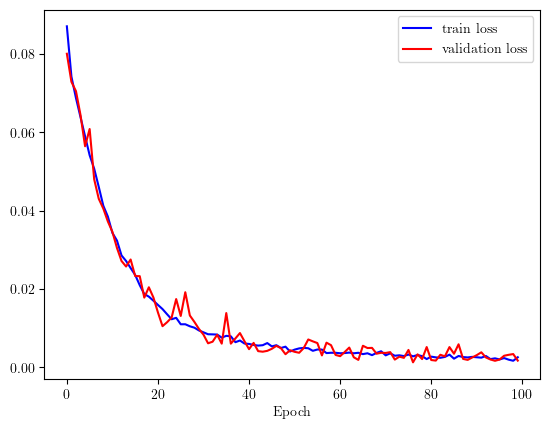

In [10]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

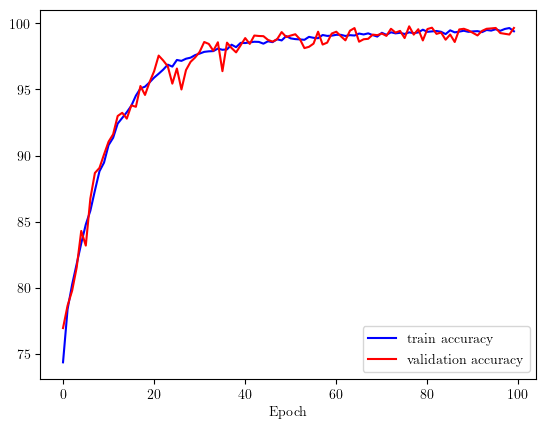

In [11]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [12]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.001610310407050799
Test accuracy:  99.69688619454395


## Compute and display traversal costs

In [13]:
# Compute the traversal costs from the features of the dataset
from params import PROJECT_PATH

costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=PROJECT_PATH / "src/traversal_cost/datasets/dataset_all_terrain",
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

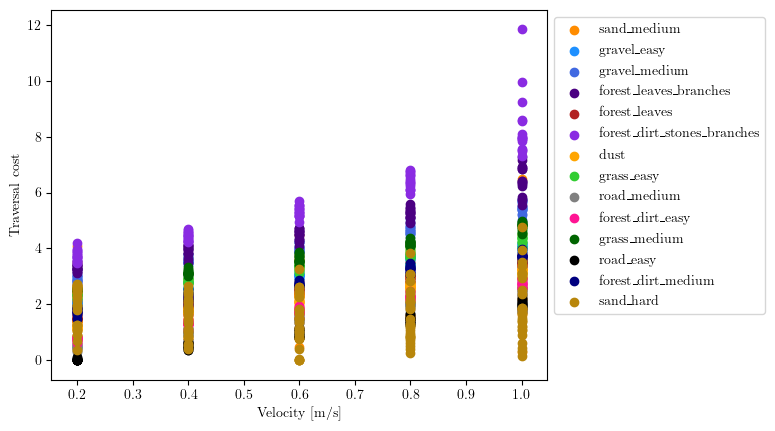

In [14]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

## Generate a log directory

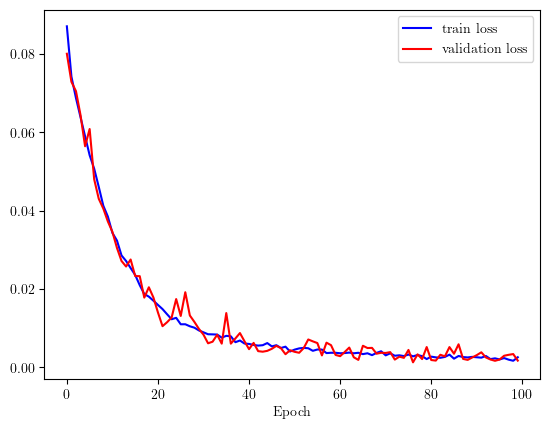

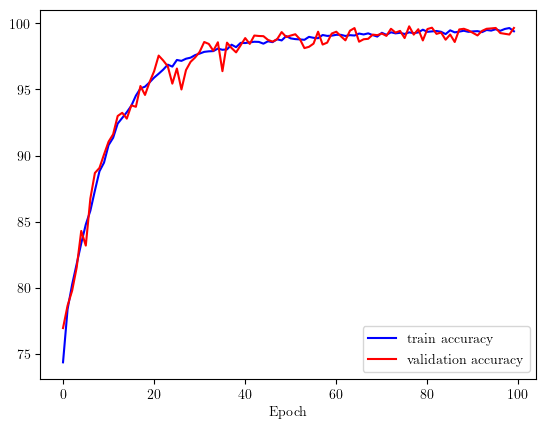

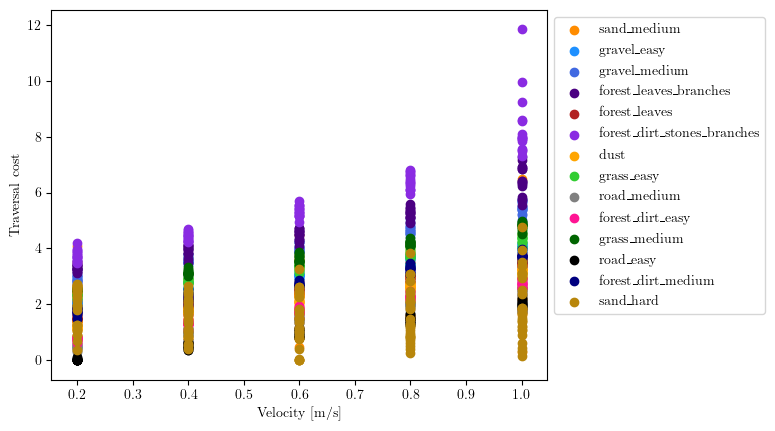

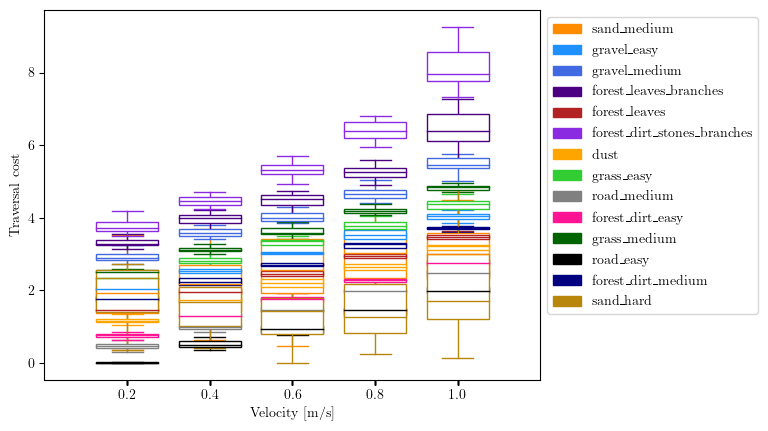

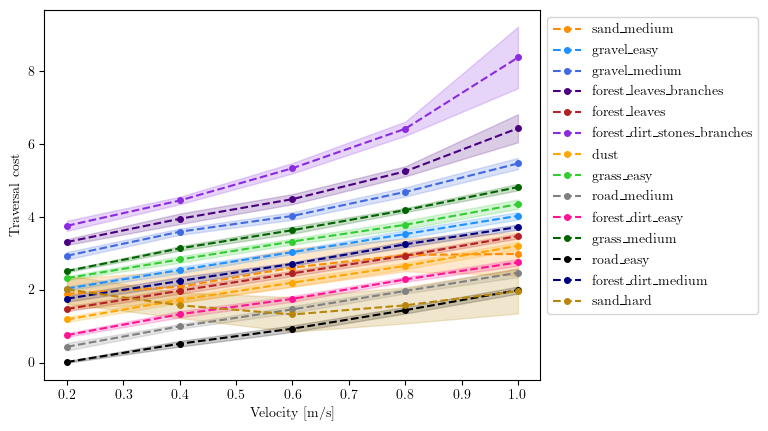

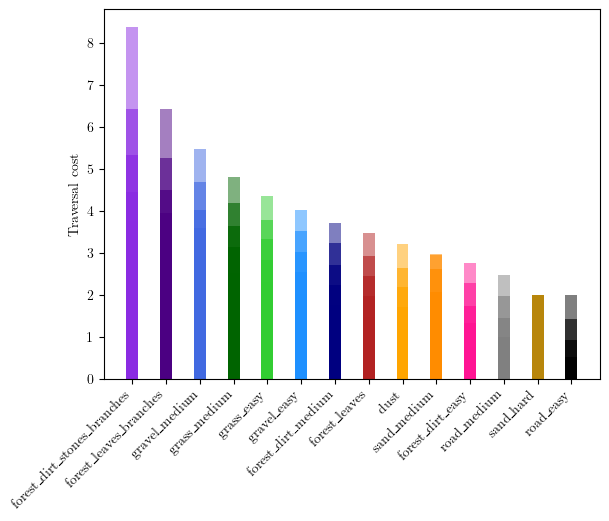

In [19]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = Path(
        "logs/_" +
        params.siamese.LOG_DIR
    )
else:
    results_directory = Path(
        "logs/_" +
        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    )
                        
# Generate the log directory
generate_log(dataset_directory=PROJECT_PATH / "src/traversal_cost/datasets/dataset_all_terrain",
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)
costs_df.to_csv(results_directory / "costs_df.csv", sep=',', encoding='utf-8')
np.save(results_directory / "mean", costs_df['cost'].mean())

In [16]:
results_directory = PROJECT_PATH / "src/traversal_cost/siamese_network/logs/_2023-09-19-15-37-35"

costs_df = pd.read_csv(results_directory / "costs_df.csv", sep=',', encoding='utf-8')
df_filtered = costs_df[costs_df['linear_velocity'] == 1.0]
df_filtered.groupby(['terrain_class']).mean()


,Unnamed: 0,linear_velocity,cost
terrain_class,,,
dust,311.5,1.0,8.465829
forest_dirt_easy,391.5,1.0,7.503398
forest_dirt_medium,791.5,1.0,10.314275
forest_dirt_stones_branches,551.5,1.0,28.817385
forest_leaves,951.5,1.0,9.580561
forest_leaves_branches,631.5,1.0,20.500881
grass_easy,71.5,1.0,12.924111
grass_medium,471.5,1.0,14.142108
gravel_easy,151.5,1.0,11.848593
